<a href="https://colab.research.google.com/github/yoniamit/batlocations/blob/main/batlocations110421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [170]:
#Imports
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

#Definations

xlb = 320.0  # x left basket
ylb = 410.0  # y left basket
xrb = 420.0  # x right basket
yrb = 60.0  # y right basket
basketradius = 40.0  # distance from the center of the basket which count as "IN"
accuracy_limit = 0.0  # Value for accuracy check 

nans_tresh  = 0.3
per_unit = 6000
gmmcomp = 3
tresh_sleep_distance = 10

#data_read_path = "/content/drive/MyDrive/Python files/20210311-161231IrTimes.txt" #path_of data to read
#data_read_path = "/content/drive/MyDrive/Python files/20210104-170423IrTimes.txt"

data_read_path = []
dict_of_info = []

data_read_path.append("/content/drive/MyDrive/Python files/20210201-202753IrTimes.txt")
dict_of_info.append({1:20493, 2 :20528, 4 :20516, 5 :20488})

data_read_path.append( "/content/drive/MyDrive/Python files/20210207-154302IrTimes.txt")
dict_of_info.append( {0: 20547, 1: 20493, 3: 62438, 4: 20516, 5: 20488})

data_read_path.append( "/content/drive/MyDrive/Python files/20210215-105316IrTimes.txt")
dict_of_info.append({0 :  20547 ,1 :  20493,3 :  62438 ,4 :  20516,5  : 20488})

data_read_path.append("/content/drive/MyDrive/Python files/20210223-205817IrTimes.txt")
dict_of_info.append({3 : 62438 ,4 : 20516,1 : 20528,2 : 20493 ,5 : 20522  ,0:  20547})

data_read_path.append("/content/drive/MyDrive/Python files/20210302-160001IrTimes.txt")
dict_of_info.append({0 :20632,1 :20616,2 :20513,3 :20488,4 :20529,5 :20595 })

data_read_path.append( "/content/drive/MyDrive/Python files/20210311-161231IrTimes.txt")
dict_of_info.append({0:20632, 1:20547, 2:20522, 3:20488, 4:20453, 5:20595})


data_read_path.append( "/content/drive/MyDrive/Python files/20210330-135215IrTimes.txt")
dict_of_info.append({0:20547, 1:20493, 3:62438, 4:20516 , 5:20488})


dict_of_colony = {
20595:	(140,92),
20632:	(185,94),
20522:	(160,91),
20516:	(142,92),
20493:	(190,94),
20616:	(180,94),
20513:	(125,89),
20488:	(125,91),
20528:	(110,88),
20457:	(90,82),
62438:	(165,87),
20592:	(140,95),
20529:	(62,75),
20453:	(170,-1) }

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]


In [171]:
def load_raw_file(mypath):
  f = open(mypath, "r")
  data = Lines = f.readlines()
  list_locations = []
  
  for line in data:
      columns = line.split(",")
      #print(columns[13] + " " + columns[14])

      xydata = columns[14].split(" ")
      xydata = [x for x in xydata if x]
      xy_accuracy_data = columns[15].split(" ")  # הוספתי
      xy_accuracy_data = [x for x in xy_accuracy_data if x]  # הוספתי
      if (len(xydata) != 2) or (len(xy_accuracy_data) != 2):  # הוספתי
          continue

      x_accuracy_data = (float(xy_accuracy_data[0].replace("[", "").replace("]", "")))  # הוספתי
      y_accuracy_data = (float(xy_accuracy_data[1].replace("[", "").replace("]", "")))  # הוספתי
      if (y_accuracy_data > accuracy_limit) or (x_accuracy_data > accuracy_limit):  # הוספתי
          continue

      x = (float(xydata[0].replace("[", "").replace("]", "")))
      y = (float(xydata[1].replace("[", "").replace("]", "")))
      dt = datetime.strptime(columns[0] + " " + columns[1] ,  "%Y%m%d %H%M%S").timestamp()  #20210104
      t = np.array([int(columns[13]), dt, x, y])
      list_locations += [t]

  list_array = np.array(list_locations)

  f.close()

  print("Done! func1!")

  return list_array





In [172]:
def time_arrange_data(list_array):
  t = 0
  minimum_time = np.min(list_array[:,1])
  maximum_time = np.max(list_array[:,1])
  time_now = minimum_time
  list_tag = np.unique(list_array[:,0])
  main_data = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit), 2))




  print(list_array[:,1])
  print(minimum_time, maximum_time)
  print(type(list_tag[0]))

  tagids  = list_array[:,0]
  dates = list_array[:,1]


  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      main_data[a,t,:] = np.mean(list_array[(tagids == list_tag[a]) & (dates> time_now) & (dates< (time_now + per_unit)) ,2:4],axis = 0)
    t += 1  
    time_now += per_unit

  tag_nans = np.zeros((len(list_tag)))
  for a in range(len(list_tag)):
    tag_nans[a] = len(main_data[a,np.isnan(main_data[a,:,0]),0])/len(main_data[a,:,0]) > nans_tresh 

  main_data = main_data[~tag_nans.astype(bool)]
  list_tag = list_tag[~tag_nans.astype(bool)]


  print("Done! func2!")
  #אינטרפולציות
  for a in range(len(list_tag)):
    y = main_data[a,:,:]
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    main_data[a,:,:] = y
  

  return main_data, list_tag, minimum_time, maximum_time

In [173]:

def compute_distance_array(main_data, list_tag, minimum_time, maximum_time):
  time_now = minimum_time
  t = 0
  distance_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      all_pos = main_data[:,t,:]
      other_bats_pos = np.delete(all_pos,a, 0)
      dist = []
      for pos in other_bats_pos:
        dist += [np.mean(np.linalg.norm(my_pos - pos))]
      dist = np.array(dist)
      dist = np.mean(dist)
      distance_array[a,t] = dist
    t += 1  
    time_now += per_unit

  
  distance_array_in_zero = distance_array[0,:] < tresh_sleep_distance
  for a in range(1, len(list_tag)):
    distance_array_in_zero = (distance_array_in_zero &  (distance_array[a,:]<tresh_sleep_distance))
  
  return distance_array, distance_array_in_zero
  
  #plt.figure()
  #plt.plot(distance_array_in_zero)
  #plt.show()
  #print(distance_array)

In [174]:
#מרחק שאני זזתי בקורולציה עם המרחק ששאר הקבוצה זזה
def temp_function():
  time_now = minimum_time + per_unit
  t = 1
  movment_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      my_prev_pos = main_data[a,t -1,:]
      thedistance = np.linalg.norm(my_pos - my_prev_pos)
      movment_array[a,t-1] = (thedistance )
    t += 1  
    time_now += per_unit

  print(movment_array)
  correlations = []
  for a in range(len(list_tag)):
    list_tag_temp = np.delete(np.array(range(len(list_tag))), a, 0).astype(int)
    correlations.append(np.correlate(movment_array[a,:],np.mean(distance_array[list_tag_temp,:], axis=0)))
    print(np.correlate(movment_array[a,:],np.mean(distance_array[list_tag_temp,:], axis=0)))

In [175]:
#המרחק שאני זזתי בקורלציה למרחק של שאר הקבוצה ממני
def movment_array_creat(main_data, list_tag, minimum_time, maximum_time):
  time_now = minimum_time + per_unit
  t = 1
  movment_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      my_prev_pos = main_data[a,t -1,:]
      thedistance = np.linalg.norm(my_pos - my_prev_pos)
      movment_array[a,t-1] = (thedistance )
    t += 1  
    time_now += per_unit

  return movment_array
  
def correlations_generator(movment_array, distance_array, distance_array_in_zero):  
  correlations = []
  for a in range(len(list_tag)):
    correlations.append(np.correlate(movment_array[a,~distance_array_in_zero],distance_array[a,~distance_array_in_zero]))

  correlations = np.array(correlations)
  print(correlations)
  print(list_tag)
  correlations = correlations-np.min(correlations)
  correlations= correlations/np.max(correlations)
  print(correlations)
  return correlations#

In [176]:
def GMM_compute(main_data, list_tag, minimum_time, maximum_time):
  maindatashape = np.shape(main_data)
  f = np.reshape([main_data[:,:,:] ] , (maindatashape[0]*maindatashape[1] , 2) )
  gm = GaussianMixture(n_components=gmmcomp, random_state=0).fit( f )
  print(gm.means_)
  print(gm.weights_)

 # fig , axs= plt.subplots(len(list_tag) ,figsize=(20,20), sharey=True)
  for a in range(len(list_tag)):
      gmpred = gm.predict(main_data[a,:,:])
      
     # axs[a].set_title("dominance is : " + str(correlations[a]))
      #axs[a].hist(gmpred , bins = range(gmmcomp+1))
      #fig.savefig('result1.png')
  return gm

In [177]:
def get_correlations_places(main_data, list_tag, minimum_time, maximum_time,gm):
  all_cor_for_pos_list = []
  for p in range(gmmcomp):
    cor_for_pos_list = []
    for a in range(len(list_tag)):
        gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
        #plt.plot(gmpred )
        cor_for_pos_list.append((correlations[a] , len(gmpred[gmpred==p])))
    cor_for_pos_list = np.array(cor_for_pos_list)
    gmmcount = cor_for_pos_list[:,1]
    gmmcount = gmmcount - np.min(gmmcount)
    gmmcount = gmmcount/np.max(gmmcount)
    cor_for_pos_list[:,1] = gmmcount
    all_cor_for_pos_list.append(cor_for_pos_list)
  return np.array(all_cor_for_pos_list) 
  #fig.savefig('dominanceVsHome0.png')

In [178]:
all_path_data =[]
for p in data_read_path:
  main_data, list_tag, minimum_time, maximum_time = time_arrange_data(load_raw_file(p))
  distance_array, distance_array_in_zero = compute_distance_array(main_data, list_tag, minimum_time, maximum_time)
  movment_array = movment_array_creat(main_data, list_tag, minimum_time, maximum_time)
  correlations = correlations_generator(movment_array, distance_array, distance_array_in_zero)
  gm = GMM_compute(main_data, list_tag, minimum_time, maximum_time)
  all_cor_for_pos_list = get_correlations_places(main_data, list_tag, minimum_time, maximum_time,gm)
  all_path_data.append((all_cor_for_pos_list, gm.means_, list_tag, correlations))
  print(list_tag)
  print("Done! Part1!")

Done! func1!
[1.61221128e+09 1.61221128e+09 1.61221128e+09 ... 1.61231476e+09
 1.61231476e+09 1.61231476e+09]
1612211276.0 1612314761.0
<class 'numpy.float64'>
Done! func2!
[[ 42316.25653768]
 [129434.14192009]
 [104228.81668501]
 [ 49253.43133102]]
[1. 2. 4. 5.]
[[0.        ]
 [1.        ]
 [0.71067565]
 [0.07962974]]
[[479.16255011 156.59068333]
 [407.78739461 247.50785312]
 [227.02128733  76.39671987]]
[0.66716995 0.229917   0.10291306]
[1. 2. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61271258e+09 1.61271259e+09 1.61271260e+09 ... 1.61301981e+09
 1.61301981e+09 1.61301981e+09]
1612712585.0 1613019814.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[507557.13209964]
 [375094.28882586]
 [170200.57097436]
 [232470.5908346 ]]
[0. 1. 4. 5.]
[[1.        ]
 [0.60735062]
 [0.        ]
 [0.18458221]]
[[245.04558977 157.91161968]
 [445.11407465 250.57759661]
 [458.17968834 137.89447284]]
[0.21374087 0.18932657 0.59693256]
[0. 1. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61338640e+09 1.61338640e+09 1.61338640e+09 ... 1.61372624e+09
 1.61372625e+09 1.61372625e+09]
1613386397.0 1613726250.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[163689.42420056]
 [215305.88040648]
 [211549.04589293]
 [257592.85676558]]
[0. 1. 4. 5.]
[[0.        ]
 [0.54967593]
 [0.5096685 ]
 [1.        ]]
[[457.83542713 109.88997004]
 [402.17243259 152.62157801]
 [172.58935656 143.5249862 ]]
[0.52153138 0.37941692 0.0990517 ]
[0. 1. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61411390e+09 1.61411390e+09 1.61411390e+09 ... 1.61453105e+09
 1.61453107e+09 1.61453110e+09]
1614113898.0 1614531103.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[584169.65043557]
 [594080.89106847]
 [732070.90220918]
 [710548.50030731]
 [421833.72255395]
 [400149.51941172]]
[0. 1. 2. 3. 4. 5.]
[[0.55440879]
 [0.58426899]
 [1.        ]
 [0.93515813]
 [0.06532933]
 [0.        ]]
[[491.34707061 361.08626483]
 [195.5335686   90.84563593]
 [437.06833749 199.45105894]]
[0.37686017 0.16907721 0.45406262]
[0. 1. 2. 3. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61470080e+09 1.61470080e+09 1.61470080e+09 ... 1.61516727e+09
 1.61516797e+09 1.61516818e+09]
1614700802.0 1615168177.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[486913.35154834]
 [379502.38409323]
 [302615.10747695]
 [497501.7943549 ]
 [351766.35376138]]
[0. 2. 3. 4. 5.]
[[0.94566872]
 [0.39452298]
 [0.        ]
 [1.        ]
 [0.25220423]]
[[351.24574065 340.95123419]
 [492.98461774 114.561954  ]
 [488.65487898 303.13700194]]
[0.08534757 0.35068415 0.56396828]
[0. 2. 3. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61547915e+09 1.61547915e+09 1.61547915e+09 ... 1.61593406e+09
 1.61593572e+09 1.61593577e+09]
1615479152.0 1615935768.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[232070.11566684]
 [279359.35664998]
 [462420.17887049]
 [227943.67999543]]
[0. 2. 3. 5.]
[[0.0175985 ]
 [0.21927859]
 [1.        ]
 [0.        ]]
[[488.98575447 195.98494352]
 [499.21475141 339.11821864]
 [360.72377589 225.97064529]]
[0.46426671 0.40066154 0.13507175]
[0. 2. 3. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61711246e+09 1.61711254e+09 1.61711254e+09 ... 1.61755570e+09
 1.61755570e+09 1.61755571e+09]
1617112459.0 1617555706.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[651328.68445748]
 [733130.99813999]
 [583242.60226885]
 [715132.03461077]]
[0. 1. 3. 5.]
[[0.45424519]
 [1.        ]
 [0.        ]
 [0.87991757]]
[[403.71868088 226.76923054]
 [184.37900552  91.26395723]
 [490.89221808 354.94959826]]
[0.44236962 0.26499172 0.29263866]
[0. 1. 3. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

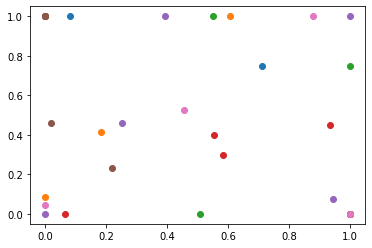

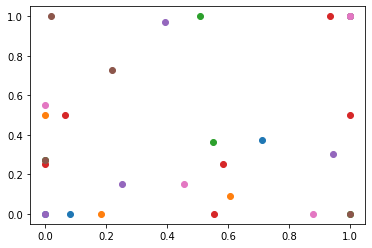

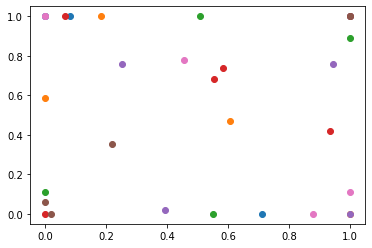

In [186]:
posind =0
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])
    #plt.scatter(all_path_data[p][0][0,:,:])
 # print(all_path_data[p][0][posind])
#model = LinearRegression().fit(x, y)
plt.figure()
posind =1
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])
plt.figure()
posind =2
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])

#print(all_path_data[0][0])

In [180]:
#import matplotlib.pyplot as plt

#fig= plt.figure()

#f = np.array(range(gmmcomp))
#for i, txt in enumerate(f):
   # plt.annotate(txt, (gm.means_[i,0], gm.means_[i,1]))
    
#plt.scatter(gm.means_[:, 0], gm.means_[:, 1])
#plt.show()
#fig.savefig('mapofplaces.png')

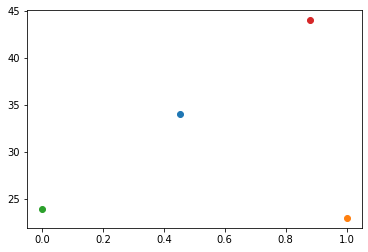

In [181]:
  fig = plt.figure()

  for a in range(len(list_tag)):
      gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
      #plt.plot(gmpred )
      plt.scatter(correlations[a] , len(gmpred[gmpred==0]))
      
  fig.savefig('dominanceVsHome0.png')

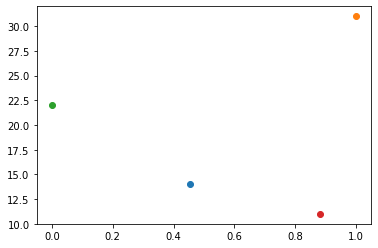

In [182]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==1]))
    
fig.savefig('dominanceVsHome1.png')

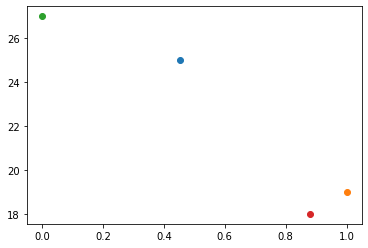

In [183]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==2]))
    
fig.savefig('dominanceVsHome2.png')